In [5]:
!pip install category-encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.2 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import time
import pickle
from scipy.stats import uniform
from textwrap import wrap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.base import clone

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.utils import check_array

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.feature_extraction import FeatureHasher

In [7]:
data = pd.read_csv('/content/data_clean.csv')

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1668 entries, 0 to 1667
Data columns (total 33 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1668 non-null   float64
 1   BuildingType                     1668 non-null   object 
 2   PrimaryPropertyType              1668 non-null   object 
 3   PropertyName                     1668 non-null   object 
 4   Address                          1668 non-null   object 
 5   TaxParcelIdentificationNumber    1668 non-null   object 
 6   Neighborhood                     1668 non-null   object 
 7   YearBuilt                        1668 non-null   float64
 8   NumberofBuildings                1668 non-null   float64
 9   NumberofFloors                   1668 non-null   float64
 10  PropertyGFATotal                 1668 non-null   float64
 11  PropertyGFAParking               1668 non-null   float64
 12  PropertyGFABuilding(

Transformation logarithmiques des variables à prédire

In [8]:
data.loc[:, ["SiteEnergyUse(kBtu)", "TotalGHGEmissions"]] = data.loc[:, ["SiteEnergyUse(kBtu)", "TotalGHGEmissions"]].apply(lambda x: np.log(1 + x))

In [16]:
y_labels = ["SiteEnergyUse(kBtu)",
            "TotalGHGEmissions",
            'Electricity(kBtu)',
            'NaturalGas(kBtu)',
            'SteamUse(kBtu)']

# Variables catégorielles
cat_attribs = list(data.select_dtypes(include='object').columns)

# Variables numériques
num_attribs = list(data.drop(columns=cat_attribs + y_labels + ["ENERGYSTARScore"]).columns)

# Liste des types d'énergie
list_energy_type = ["Electricity(kBtu)",
                    "NaturalGas(kBtu)",
                    "SteamUse(kBtu)"]

Transformation de la présence du type d'energie en booleen

In [17]:
class AddBooleanEnergyType(BaseEstimator, TransformerMixin) :

    def __init__(self, add_Boolean_EnergyType=True) :
        self.add_Boolean_EnergyType = add_Boolean_EnergyType
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if self.add_Boolean_EnergyType :

            return np.array(X > 0) * 1
        else :
            return X

Definition des pipelines

In [18]:
# Pipeline pour les variables numériques
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler()), # Normalisation des données
    ])

# Pipeline pour les variables catégorielles
cat_pipeline = Pipeline(steps=[
    ('target', TargetEncoder()),
    ('std_scaler', StandardScaler()), # Normalisation des données
    ])

# Pipeline pour les variables booléennes
add_bool_pipeline = Pipeline([
    ('bool_energy', AddBooleanEnergyType())
])

In [20]:
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("energyType", add_bool_pipeline, list_energy_type),
        ("cat", cat_pipeline, cat_attribs),
    ])

In [21]:
full_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('std_scaler',
                                                  StandardScaler())]),
                                 ['OSEBuildingID', 'YearBuilt',
                                  'NumberofBuildings', 'NumberofFloors',
                                  'PropertyGFATotal', 'PropertyGFAParking',
                                  'PropertyGFABuilding(s)',
                                  'LargestPropertyUseTypeGFA',
                                  'SecondLargestPropertyUseTypeGFA',
                                  'ThirdLargestPropertyUseTypeGFA',
                                  'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/...
                                 ['Electricity(kBtu)', 'NaturalGas(kBtu)',
                                  'SteamUse(kBtu)']),
                                ('cat',
                                 Pipeline(steps=[('target', TargetEncoder()),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['BuildingType', 'PrimaryPropertyType',
                                  'PropertyName', 'Address',
                                  'TaxParcelIdentificationNumber',
                                  'Neighborhood', 'ListOfAllPropertyUseTypes',
                                  'LargestPropertyUseType',
                                  'SecondLargestPropertyUseType',
                                  'ThirdLargestPropertyUseType'])])

Separation des données

In [22]:
train_set, test_set = train_test_split(data, train_size=0.8, random_state=0)

In [23]:
# Distribution des indices train/validation pour obtenir des jeux train/validation pour la validation croissé
kf = KFold(n_splits=5)

In [25]:
# Dictionnaires de résultats
y_pred = {}
rmse = {}
mae = {}
final_model = {}

In [27]:
def display_scores(scores, scoring=["neg_mean_squared_error", "neg_mean_absolute_error"]) :
    print("Resultats de la cross validation:")

    for metric in scoring :

        results = -scores["test_" + metric]
        if metric == "neg_mean_squared_error" :
            print("Métrique utilisé : RMSE")
            results = np.sqrt(results)
        else :
            print("Métrique utilisé : MAE")
        print("\t - Moyenne : {:.3f}".format(results.mean()))
        print("\t - Ecart-type : {:.3f}".format(results.std()))
        print("\t - Coefficient de variation : {:.2f} %".format(results.std()/results.mean()*100))
        print("\n")

In [28]:
def mean_absolute_percentage_error(y_true, y_pred):
    # MAPE : Mean aboslute percentage error
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [29]:
def define_pipeline(preprocessor, regressor) :
    # Assembly of preprocessor and regressor
    pipe = Pipeline([("preprocess", preprocessor),
                    ("regressor", regressor),
                    ])
    return pipe

In [41]:
# Affichage d'un barplot des résultats : moyenne, écart-type et coefficient de variation
def graphical_display(results, title) :

    x = list(results)
    y = np.array(list(results.values()))
    rmse_mean = [score.mean() for score in np.array(list(results.values()))]
    rmse_std = [score.std() for score in np.array(list(results.values()))]

    # Liste des couleurs pour chaque segment
    palette = sns.color_palette()
    colors = palette.as_hex()[0: len(results)]

    fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(10,5))
    fig.suptitle(title, fontsize=18)
    axs[0].bar(x=x, height=rmse_mean, color=colors)
    axs[0].set_ylabel("Mean")
    axs[0].errorbar(range(len(rmse_mean)), rmse_mean.values(), yerr=list(rmse_std.values()), fmt='none', ecolor='black')
    #axs[0].errorbar(range(len(rmse_mean)), rmse_mean, yerr=rmse_std, fmt='none', ecolor='black')
    axs[1].bar(x=x, height=rmse_std, color=colors)
    axs[1].set_ylabel("Variance")

    plt.show()

# **Prédiction de l'énergie totale**

In [31]:
regressors = {
                   'Dummy': DummyRegressor(),
                   'Elastic Net' : ElasticNet(max_iter=1000),
                   'SVR': SVR(kernel="rbf", C=300, gamma=1),
                   'Random Forest': RandomForestRegressor(n_estimators=100, n_jobs=-1),
                   'Extra Tree': ExtraTreesRegressor(n_estimators=100, n_jobs=-1),
                   'Gradient Boosting': GradientBoostingRegressor(n_estimators=100),
                  }

_____ Dummy _____
Resultats de la cross validation:
Métrique utilisé : RMSE
	 - Moyenne : 1.839
	 - Ecart-type : 0.174
	 - Coefficient de variation : 9.45 %


Métrique utilisé : MAE
	 - Moyenne : 1.122
	 - Ecart-type : 0.034
	 - Coefficient de variation : 3.06 %


_____ Elastic Net _____
Resultats de la cross validation:
Métrique utilisé : RMSE
	 - Moyenne : 1.835
	 - Ecart-type : 0.173
	 - Coefficient de variation : 9.44 %


Métrique utilisé : MAE
	 - Moyenne : 1.117
	 - Ecart-type : 0.031
	 - Coefficient de variation : 2.81 %


_____ SVR _____
Resultats de la cross validation:
Métrique utilisé : RMSE
	 - Moyenne : 1.798
	 - Ecart-type : 0.189
	 - Coefficient de variation : 10.52 %


Métrique utilisé : MAE
	 - Moyenne : 1.037
	 - Ecart-type : 0.037
	 - Coefficient de variation : 3.61 %


_____ Random Forest _____
Resultats de la cross validation:
Métrique utilisé : RMSE
	 - Moyenne : 1.565
	 - Ecart-type : 0.119
	 - Coefficient de variation : 7.63 %


Métrique utilisé : MAE
	 - Moyenn

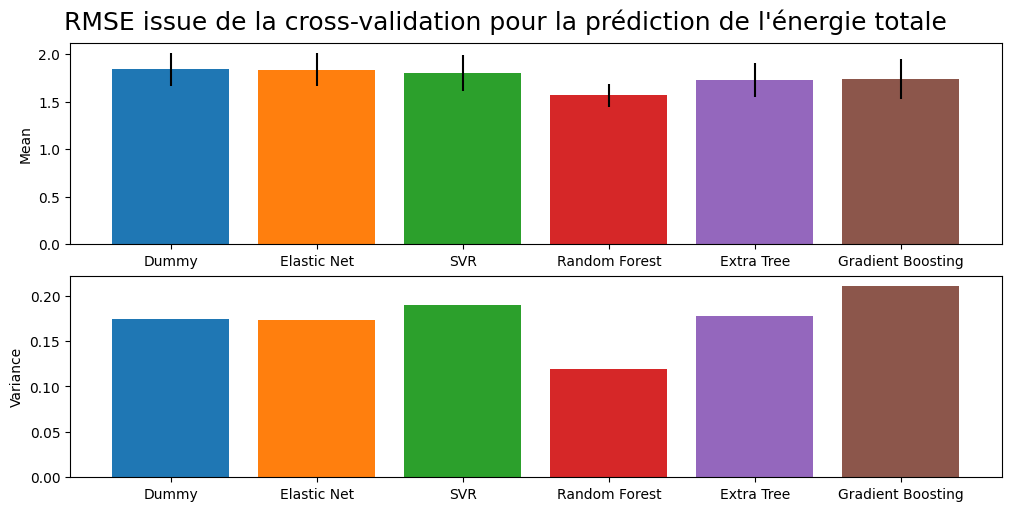

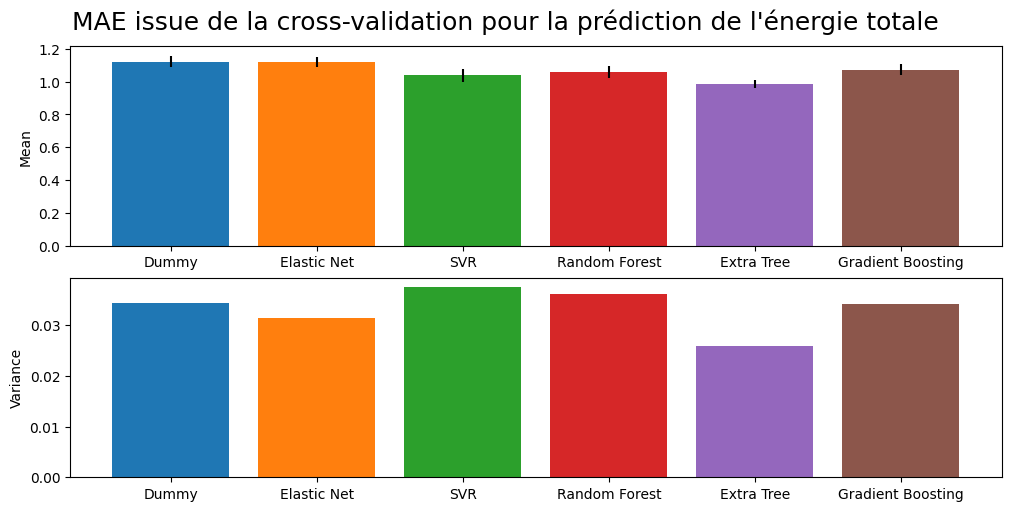

In [32]:
# Les regressors sont testés 1 à 1 par cross-validation
for name_reg, reg in regressors.items() :
    print("_____", name_reg, "_____")

    pipeline = define_pipeline(full_pipeline, reg)
    # cross-validation
    scores = cross_validate(pipeline,
                            train_set,
                            train_set["SiteEnergyUse(kBtu)"],
                            scoring=["neg_mean_squared_error",
                                     "neg_mean_absolute_error"],
                            cv=kf)
    # calcul de la RMSE
    rmse[name_reg] = np.sqrt(-scores["test_neg_mean_squared_error"])
    # calcul de la MAE
    mae[name_reg] = -scores["test_neg_mean_absolute_error"]

    # Affichage des résultats
    display_scores(scores,
                   scoring = ["neg_mean_squared_error",
                              "neg_mean_absolute_error"])

# Affichage des résultats de la RMSE
graphical_display(rmse, "RMSE issue de la cross-validation pour la prédiction de l'énergie totale")

# Affichage des résultats de la MAE
graphical_display(mae, "MAE issue de la cross-validation pour la prédiction de l'énergie totale")

3 Modèles se démarquent des autres et offrent sensiblement les mêmes résultats, il s'agit de :
Random Forest, Extra Tree et dans une moindre mesure Gradient boosting.
Dans la suite, nous alloons hyper-paramétriser ces 3 modèles dans le but d'affiner les résultats

In [33]:
# Dictionnaire des Random Search pour conserver tous les résultats
rnd_search_results = {}

In [54]:
def rnd_search(regressors, pipeline, param_grid, X, y, n_splits=5, display=True) :
    kf = KFold(n_splits=n_splits)

    rnd_search_dict = {}

    # Meilleur score
    best_score = float('inf')
    # Dictionnaire des modèles hyperparamétrés
    rmse_mean, rmse_std = {}, {}
    fit_time_mean, fit_time_std = {}, {}

    for name_reg, regressor in regressors.items() :

        print(name_reg)
        prepare_select_and_predict_pipeline = define_pipeline(pipeline, regressor)


        rnd_search_prep = RandomizedSearchCV(prepare_select_and_predict_pipeline,
                                             param_grid[name_reg],
                                             n_iter=100,
                                             scoring='neg_mean_squared_error',
                                             cv=kf,
                                             random_state=42)

        # Entrainement du modèle
        rnd_search_prep.fit(X, y)
        rnd_search_dict[name_reg] = rnd_search_prep

        best_model_index = rnd_search_prep.best_index_
        score = [np.sqrt(-rnd_search_prep.cv_results_["split" + str(i) + "_test_score"][best_model_index])
                 for i in range(n_splits)]

        # Temp d'entrainement du modèle
        fit_time_mean[name_reg] = rnd_search_prep.cv_results_['mean_fit_time'][best_model_index]
        fit_time_std[name_reg] = rnd_search_prep.cv_results_['std_fit_time'][best_model_index]

        # Moyenne et écart-type de la RMSE
        mean_score, std_score = np.mean(score), np.std(score)
        rmse_mean[name_reg], rmse_std[name_reg] = mean_score, std_score
        score = rnd_search_prep.best_estimator_.score(X, y)

        print("Paramètres du meilleur modèle : \n")
        for params, values in rnd_search_prep.best_params_.items():
             print("\t - ", params, ":", values)
        print("\nRésultats :")
        print("\n\t - r2 score sur le jeu d'entrainement : {:.3f}".format(score))
        print("\t - RMSE : {:.3f}".format(mean_score))
        print("\t - Ecart-type : {:.3f}".format(std_score))
        print("\t - Coefficient de variation : {:.2f} % \n".format(std_score/mean_score*100))

        if mean_score < best_score :
            best_score = mean_score
            best_model = rnd_search_prep.best_estimator_

    return rnd_search_dict

In [52]:
# Modèles à hyper-paramétriser
regressors_2 = {
                'Gradient Boosting': GradientBoostingRegressor(random_state=42),
                'Random Forest': RandomForestRegressor(random_state=42),
                'Extra Forest': ExtraTreesRegressor(random_state=42)
}

In [53]:
# Hyperparamères pour les modèles ensemblistes d'arbres de regression
param_grid_reg_tree = {
    'regressor__n_estimators': [100],
    'regressor__max_depth': range(2, 20, 2),
    'regressor__max_features': range(2, 20, 2)
}

# Ajout du paramètre learning rate pour le Gradient Boosting
param_grid_gb = param_grid_reg_tree.copy()
param_grid_gb["regressor__learning_rate"] = [0.01, 0.05, 0.1]
param_grid_gb["regressor__n_estimators"] = [50, 100, 300]

# Dictionnaire de grille de paramètres
param_grid = {'Gradient Boosting': param_grid_gb,
              'Random Forest': param_grid_reg_tree,
              'Extra Forest': param_grid_reg_tree,
             }

In [55]:
import numpy as np
import matplotlib.pyplot as plt

rnd_search_results["SiteEnergyUse(kBtu)"] = rnd_search(regressors_2,
                                               full_pipeline,
                                               param_grid,
                                               train_set,
                                               train_set["SiteEnergyUse(kBtu)"])

Gradient Boosting
Paramètres du meilleur modèle : 

	 -  regressor__n_estimators : 300
	 -  regressor__max_features : 2
	 -  regressor__max_depth : 4
	 -  regressor__learning_rate : 0.1

Résultats :

	 - r2 score sur le jeu d'entrainement : 1.000
	 - RMSE : 1.017
	 - Ecart-type : 0.098
	 - Coefficient de variation : 9.60 % 

Random Forest


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Paramètres du meilleur modèle : 

	 -  regressor__n_estimators : 100
	 -  regressor__max_features : 2
	 -  regressor__max_depth : 18

Résultats :

	 - r2 score sur le jeu d'entrainement : 0.997
	 - RMSE : 0.982
	 - Ecart-type : 0.088
	 - Coefficient de variation : 9.00 % 

Extra Forest


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Paramètres du meilleur modèle : 

	 -  regressor__n_estimators : 100
	 -  regressor__max_features : 2
	 -  regressor__max_depth : 16

Résultats :

	 - r2 score sur le jeu d'entrainement : 0.997
	 - RMSE : 1.230
	 - Ecart-type : 0.167
	 - Coefficient de variation : 13.56 % 



In [56]:
print(rnd_search_results["SiteEnergyUse(kBtu)"])

{'Gradient Boosting': RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('std_scaler',
                                                                                                StandardScaler())]),
                                                                               ['OSEBuildingID',
                                                                                'YearBuilt',
                                                                                'NumberofBuildings',
                                                                                'NumberofFloors',
                                                                                'PropertyGFATotal',
                                         

Random Forest semble être le meilleur choix parmi les trois modèles analysés. Il atteint un score r² élevé tout en ayant une erreur RMSE moyenne plus faible et une variabilité plus modérée que les autres modèles.

In [59]:
final_model["SiteEnergyUse(kBtu)"] = rnd_search_results["SiteEnergyUse(kBtu)"]['Random Forest'].best_estimator_

# Prédiction des proportions d'énergie

In [58]:
for energy_type in list_energy_type:

    print("______________" + energy_type + "______________")

    rnd_search_results[energy_type] = rnd_search(regressors_2,
                                               full_pipeline,
                                               param_grid,
                                               train_set,
                                               train_set[energy_type],
                                               display=False)

______________Electricity(kBtu)______________
Gradient Boosting
Paramètres du meilleur modèle : 

	 -  regressor__n_estimators : 100
	 -  regressor__max_features : 2
	 -  regressor__max_depth : 2
	 -  regressor__learning_rate : 0.05

Résultats :

	 - r2 score sur le jeu d'entrainement : 0.962
	 - RMSE : 5987243.694
	 - Ecart-type : 1720355.642
	 - Coefficient de variation : 28.73 % 

Random Forest


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Paramètres du meilleur modèle : 

	 -  regressor__n_estimators : 100
	 -  regressor__max_features : 2
	 -  regressor__max_depth : 6

Résultats :

	 - r2 score sur le jeu d'entrainement : 0.959
	 - RMSE : 6050172.262
	 - Ecart-type : 1722276.296
	 - Coefficient de variation : 28.47 % 

Extra Forest


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Paramètres du meilleur modèle : 

	 -  regressor__n_estimators : 100
	 -  regressor__max_features : 2
	 -  regressor__max_depth : 12

Résultats :

	 - r2 score sur le jeu d'entrainement : 0.992
	 - RMSE : 5984743.029
	 - Ecart-type : 1707679.094
	 - Coefficient de variation : 28.53 % 

______________NaturalGas(kBtu)______________
Gradient Boosting
Paramètres du meilleur modèle : 

	 -  regressor__n_estimators : 100
	 -  regressor__max_features : 2
	 -  regressor__max_depth : 2
	 -  regressor__learning_rate : 0.05

Résultats :

	 - r2 score sur le jeu d'entrainement : 0.942
	 - RMSE : 2308102.037
	 - Ecart-type : 385820.900
	 - Coefficient de variation : 16.72 % 

Random Forest


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Paramètres du meilleur modèle : 

	 -  regressor__n_estimators : 100
	 -  regressor__max_features : 2
	 -  regressor__max_depth : 6

Résultats :

	 - r2 score sur le jeu d'entrainement : 0.922
	 - RMSE : 2282634.484
	 - Ecart-type : 390319.329
	 - Coefficient de variation : 17.10 % 

Extra Forest


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Paramètres du meilleur modèle : 

	 -  regressor__n_estimators : 100
	 -  regressor__max_features : 2
	 -  regressor__max_depth : 18

Résultats :

	 - r2 score sur le jeu d'entrainement : 0.998
	 - RMSE : 2250775.583
	 - Ecart-type : 402224.374
	 - Coefficient de variation : 17.87 % 

______________SteamUse(kBtu)______________
Gradient Boosting
Paramètres du meilleur modèle : 

	 -  regressor__n_estimators : 300
	 -  regressor__max_features : 2
	 -  regressor__max_depth : 6
	 -  regressor__learning_rate : 0.1

Résultats :

	 - r2 score sur le jeu d'entrainement : 1.000
	 - RMSE : 920647.635
	 - Ecart-type : 147767.521
	 - Coefficient de variation : 16.05 % 

Random Forest


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Paramètres du meilleur modèle : 

	 -  regressor__n_estimators : 100
	 -  regressor__max_features : 2
	 -  regressor__max_depth : 10

Résultats :

	 - r2 score sur le jeu d'entrainement : 0.976
	 - RMSE : 902585.758
	 - Ecart-type : 151025.513
	 - Coefficient de variation : 16.73 % 

Extra Forest


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Paramètres du meilleur modèle : 

	 -  regressor__n_estimators : 100
	 -  regressor__max_features : 2
	 -  regressor__max_depth : 18

Résultats :

	 - r2 score sur le jeu d'entrainement : 1.000
	 - RMSE : 868787.536
	 - Ecart-type : 135456.363
	 - Coefficient de variation : 15.59 % 



In [60]:
mean_rmse_dict, std_rmse_dict = {}, {}
mean_fit_time_dict, std_fit_time_std = {}, {}

for name_reg in regressors_2.keys():

    mean_rmse_dict[name_reg] = {}
    mean_fit_time_dict[name_reg] = {}
    std_fit_time_std[name_reg] = {}
    std_rmse_dict[name_reg] = {}

    for energy_type in list_energy_type:

        rnd_search_prep = rnd_search_results[energy_type][name_reg]
        best_model_index = rnd_search_prep.best_index_
        rmse = [np.sqrt(-rnd_search_prep.cv_results_["split" + str(i) + "_test_score"][best_model_index])
                 for i in range(5)]
        mean_fit_time_dict[name_reg][energy_type] = rnd_search_prep.cv_results_['mean_fit_time'][best_model_index]
        std_fit_time_std[name_reg][energy_type] = rnd_search_prep.cv_results_['std_fit_time'][best_model_index]

        mean_rmse_dict[name_reg][energy_type] = np.mean(rmse)
        std_rmse_dict[name_reg][energy_type] = np.std(rmse)

Il y a légère avantage pour l'Extra Forest qui présente la RMSE la moins élevé pour l'ensemble des types d'énergie avec des variances qui permettent une meilleure généralisation du modèle. En termes de temps d'entrainement du modèle, c'est également l'Extra Tree qui présente les meilleurs résultats

In [66]:
# Les meilleurs modèles sont conservés dans un dictionnaire de modèles
final_model["Electricity(kBtu)"] = rnd_search_results["Electricity(kBtu)"]["Extra Forest"].best_estimator_
final_model["SteamUse(kBtu)"] = rnd_search_results["SteamUse(kBtu)"]["Extra Forest"].best_estimator_
final_model["NaturalGas(kBtu)"] = rnd_search_results["NaturalGas(kBtu)"]["Extra Forest"].best_estimator_

# Prédiction du CO2

In [67]:
num_attribs_Co2 = num_attribs.copy()
# Ajout de l'Energy Star Score dont on va étudier son utilité pour la prédiction du Co2
num_attribs_Co2.extend(["ENERGYSTARScore"])
cat_attribs_Co2 = cat_attribs.copy()

In [68]:
class AddEnergyTypePredicted(BaseEstimator, TransformerMixin) :

    def __init__(self, list_energy_type) :
        self.list_energy_type = list_energy_type
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        Y = []
        for energy_type in self.list_energy_type:
            Y.append(final_model[energy_type].predict(X))
        return np.array(Y).T

In [69]:
num_pipeline_Co2 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('std_scaler', StandardScaler()),
    ])

# Pipeline pour les variables catégorielles
cat_pipeline_Co2 = Pipeline(steps=[
    ('target', TargetEncoder()),
    ('std_scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ])

# Pipeline pour les variables énergétiques (ajout des prédictions)
energy_pipeline = Pipeline([
    ('bool_energy', AddEnergyTypePredicted(list_energy_type + ["SiteEnergyUse(kBtu)"]))
])

# Pipeline de transformation des variables pour la prédiction du Co2
full_pipeline_co2 = ColumnTransformer([
        ("num", num_pipeline_Co2, num_attribs_Co2),
        ("energyType", energy_pipeline, list(train_set.columns)),
        ("cat", cat_pipeline_Co2, cat_attribs_Co2),
    ])

In [70]:
rnd_search_results["TotalGHGEmissions"] = rnd_search(regressors_2,
                                                     full_pipeline_co2,
                                                     param_grid,
                                                     train_set,
                                                     train_set["TotalGHGEmissions"])

Gradient Boosting
Paramètres du meilleur modèle : 

	 -  regressor__n_estimators : 100
	 -  regressor__max_features : 2
	 -  regressor__max_depth : 2
	 -  regressor__learning_rate : 0.05

Résultats :

	 - r2 score sur le jeu d'entrainement : 0.968
	 - RMSE : 0.891
	 - Ecart-type : 0.038
	 - Coefficient de variation : 4.22 % 

Random Forest


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Paramètres du meilleur modèle : 

	 -  regressor__n_estimators : 100
	 -  regressor__max_features : 2
	 -  regressor__max_depth : 8

Résultats :

	 - r2 score sur le jeu d'entrainement : 0.987
	 - RMSE : 0.906
	 - Ecart-type : 0.037
	 - Coefficient de variation : 4.10 % 

Extra Forest


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Paramètres du meilleur modèle : 

	 -  regressor__n_estimators : 100
	 -  regressor__max_features : 2
	 -  regressor__max_depth : 16

Résultats :

	 - r2 score sur le jeu d'entrainement : 0.994
	 - RMSE : 0.916
	 - Ecart-type : 0.035
	 - Coefficient de variation : 3.87 % 



Extra Tree a le meilleur R2 score et le plus faible coefficient de variation, indiquant une meilleure explication de la variance observée et une plus grande cohérence des prédictions.

In [71]:
final_model["TotalGHGEmissions"] = rnd_search_results["TotalGHGEmissions"]["Gradient Boosting"].best_estimator_

# Influence de l'ENERGYSTARScore

In [72]:
def plot_feature_importances(feature_importances, attributes):

    # Les features sont triés par importance pour l'affichage graphique
    features = np.array([[feature, attrib] for feature, attrib in sorted(zip(feature_importances, attributes), reverse=True)])
    features_labels = [attrib for value, attrib in sorted(zip(feature_importances, attributes), reverse=True)]
    features_values = [value for value, attrib in sorted(zip(feature_importances, attributes), reverse=True)]

    # Affichage Bar Plot
    fig = plt.figure(1, figsize=(25, 5))
    plt.subplot(121)
    sns.barplot(x=features_labels[0:20], y=[100*v for v in features_values[0:20]], orient='v')
    plt.ylabel("%")
    plt.title("Features Importances")
    plt.xticks(rotation=90)

    # Affichage Pieplot ENERGYSTARScore
    plt.subplot(122)
    feat_imp_energystarscore = features_values[features_labels.index('ENERGYSTARScore')]
    values = [1-feat_imp_energystarscore, feat_imp_energystarscore]
    plt.pie(values, labels=["Other Features", "ENERGYSTARScore"],
            autopct='%1.1f%%')
    plt.title("Importance relative de l'ENERGYSTARScore par rapport à l'ensemble des autres features")
    plt.show()

Liste des variables les plus influentes pour la prédiction des émissions de CO2

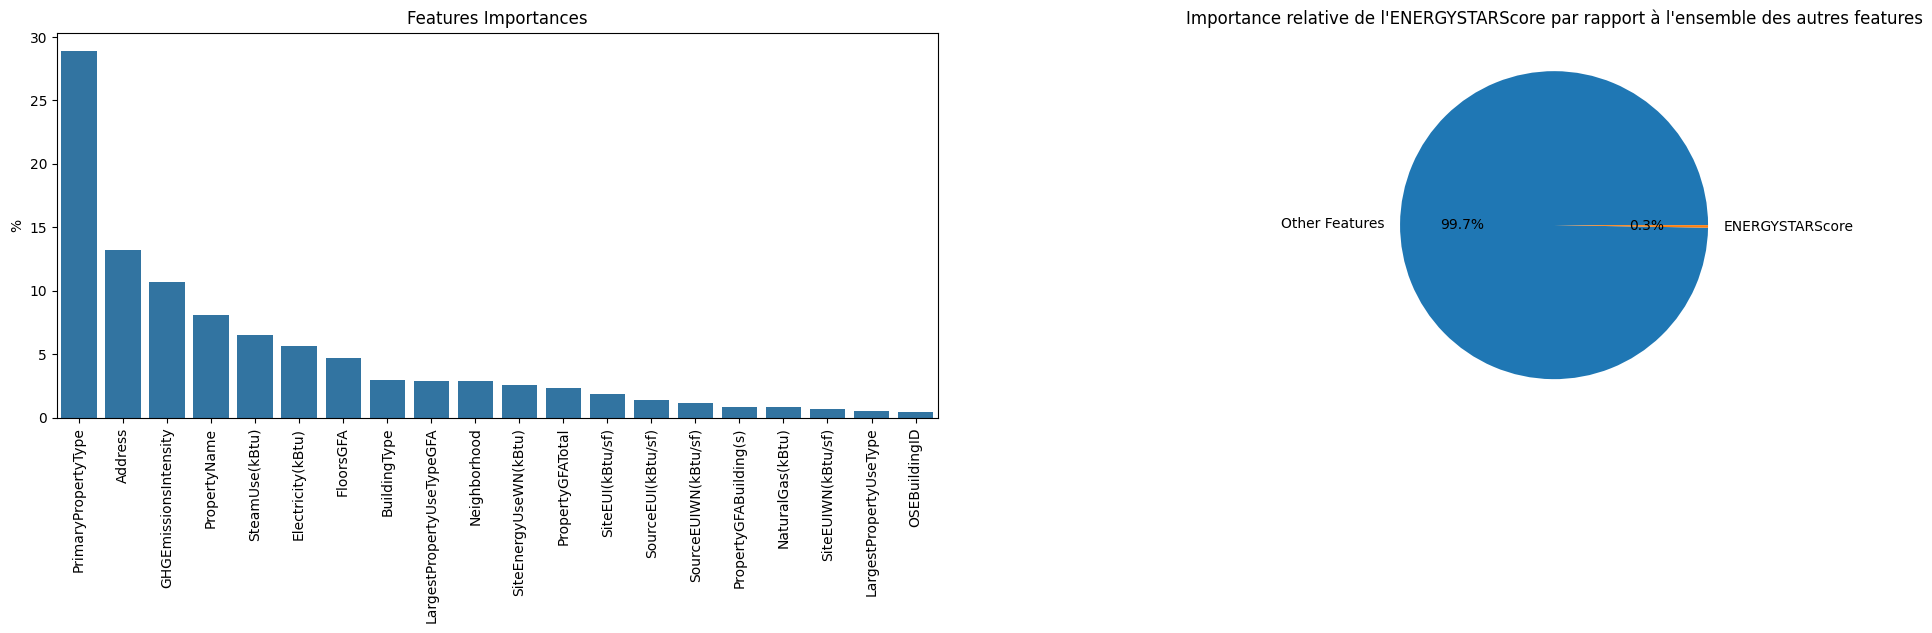

In [73]:
# On récupère les valeurs de l'importance de chaque feature
feature_importances = final_model["TotalGHGEmissions"][-1].feature_importances_

# Liste de tous les attributs
extra_attribs = ["FloorsGFA"]
attributes = num_attribs_Co2 + extra_attribs + list_energy_type + ["SiteEnergyUse(kBtu)"] + cat_attribs_Co2

# Affiche le graphique de l'importance des features
plot_feature_importances(feature_importances, attributes)

ENERGYSTARScore n'a que très peu d'influence sur le calcul de la prédiction du CO2

# Prédictions sur les données

In [74]:
# Fonction pour la transformation inverse sur nos variables à prédire
f = lambda x : np.exp(x) - 1
y_test_true = test_set.copy().reset_index()

In [76]:
y_test_pred = pd.DataFrame()

# Resultats sur le jeu Test
print("Resultats sur le jeu Test :", "\n")
for label in ["SiteEnergyUse(kBtu)", "TotalGHGEmissions"] :
    print("_______", label, "_______")

    y_test_pred[label] = final_model[label].predict(test_set)

    y_true, y_pred = y_test_true[label].apply(f), y_test_pred[label].apply(f)

    r2 = final_model[label].score(test_set, test_set[label])
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mean_abs_error = mean_absolute_error(y_true, y_pred)


    print("r2 score :", r2)
    print("rmse :", rmse)
    print("mean absolute error :", mean_abs_error, "\n")

Resultats sur le jeu Test : 

_______ SiteEnergyUse(kBtu) _______
r2 score : 0.6522757530400493
rmse : 9902911.4730699
mean absolute error : 3755882.9222283363 

_______ TotalGHGEmissions _______
r2 score : 0.45926447350272526
rmse : 217.34368048494744
mean absolute error : 90.64030054272502 



Visualisation des erreurs

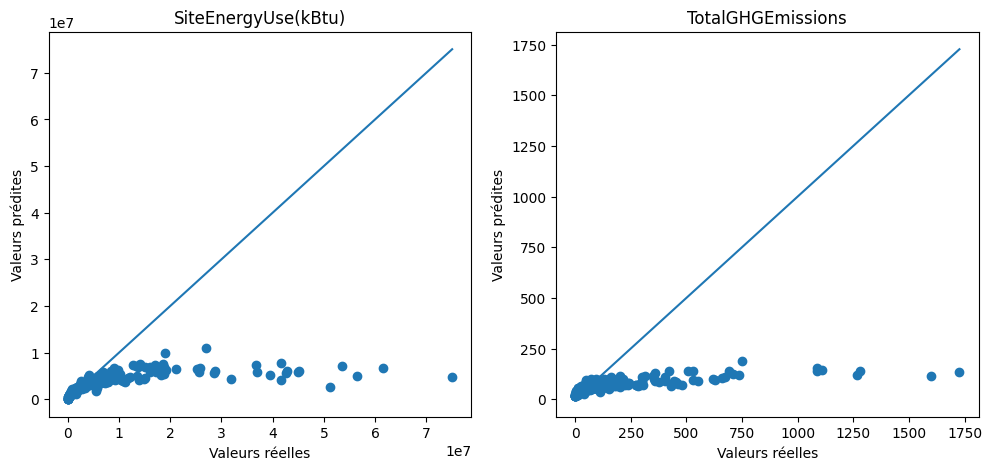

In [77]:
fig = plt.figure(1, figsize=(12,5))
for i, label in enumerate(["SiteEnergyUse(kBtu)", "TotalGHGEmissions"]) :

    y_true, y_pred = y_test_true[label].apply(f), y_test_pred[label].apply(f)

    ax = plt.subplot(1,2,i+1)
    ax.set_title(label)
    plt.xlabel("Valeurs réelles")
    plt.ylabel("Valeurs prédites")
    plt.scatter(y_true, y_pred)

    x_max = max(y_true.max(), y_pred.max())
    x_min = min(y_true.min(), y_pred.min())
    plt.plot([x_min, x_max] ,[x_min, x_max])

plt.show()

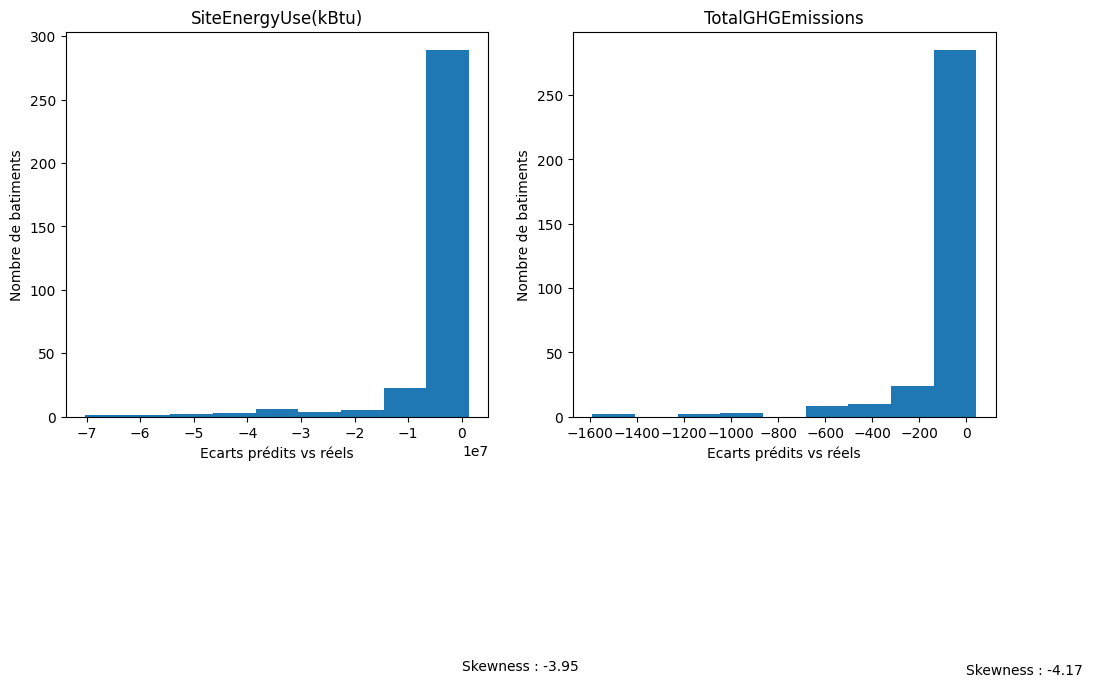

In [78]:
fig = plt.figure(1, figsize=(12,5))
for i, label in enumerate(["SiteEnergyUse(kBtu)", "TotalGHGEmissions"]) :
    ax = plt.subplot(1,2,i+1)
    ax = plt.subplot(1,2,i+1)
    ax.set_title(label)
    plt.xlabel("Ecarts prédits vs réels")
    plt.ylabel("Nombre de batiments")
    y = y_test_pred[label].apply(f) - y_test_true[label].apply(f)
    plt.hist(y, bins=int(1 + np.log2(len(test_set))))
    plt.text(0, -200, 'Skewness : ' + str(round(y.skew(),2)))
plt.show()

L'écart de prédiction n'est pas très symétrique

Visualisation graphique des erreurs

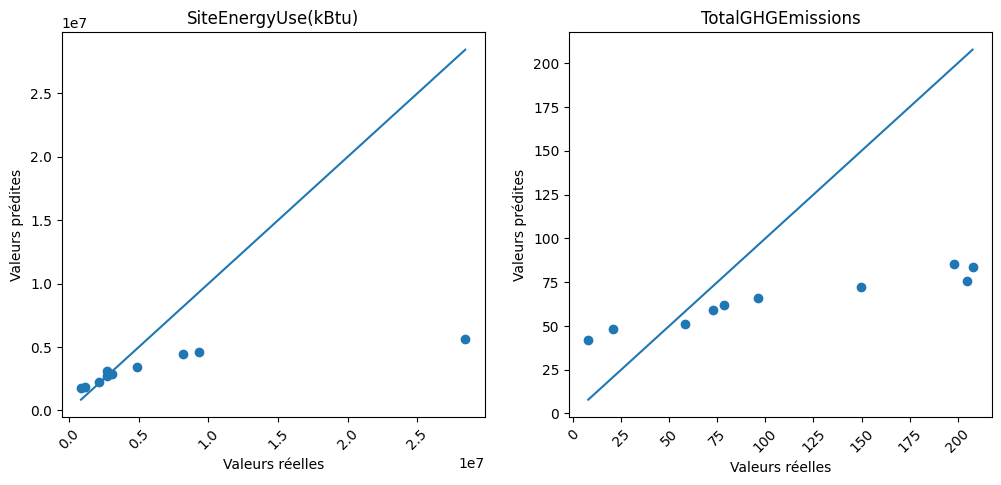

In [79]:
# 10 batiments séléctionnés aléatoirement
nbr_batiments=10
index_bat = np.random.permutation(y_test_true.index)[0:nbr_batiments]

# Séléction des 10 bâtiments
bat_table = y_test_true.loc[index_bat]

fig = plt.figure(1, figsize=(12,5))
for i, label in enumerate(["SiteEnergyUse(kBtu)", "TotalGHGEmissions"]) :
    # valeurs test réelles et valeurs test prédites
    y_true, y_pred = y_test_true.loc[index_bat, label].apply(f), y_test_pred.loc[index_bat, label].apply(f)

    bat_table[label]  = y_true
    # Calcul de l'écart relatif entre valeurs réelles et valeurs prédites
    bat_table[label + " %"] = 100*abs(y_true - y_pred)/y_true

    ax = plt.subplot(1,2,i+1)
    ax.set_title(label)
    plt.xlabel("Valeurs réelles")
    plt.ylabel("Valeurs prédites")
    plt.scatter(y_true, y_pred)

    x_max = max(y_true.max(), y_pred.max())
    x_min = min(y_true.min(), y_pred.min())

    plt.xticks(rotation=45)

    plt.plot([x_min, x_max] ,[x_min, x_max])
plt.show()

In [80]:
bat_table

,index,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Address,TaxParcelIdentificationNumber,Neighborhood,YearBuilt,NumberofBuildings,...,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),DefaultData,TotalGHGEmissions,GHGEmissionsIntensity,SiteEnergyUse(kBtu) %,TotalGHGEmissions %
183,1623,49945.0,NonResidential,Senior Care Community,Market Garage,1426 WESTERN AVE,6598350000,DOWNTOWN,1989.0,1.0,...,2.737535e+06,2.842128e+06,0.0,1888063.00,8.494710e+05,False,58.28,0.30,12.476806,12.539917
321,170,279.0,SPS-District K-12,K-12 School,West Seattle High,3000 California Ave SW,8702100050,SOUTHWEST,2002.0,1.0,...,8.164853e+06,9.030149e+06,0.0,4894851.00,3.270002e+06,True,207.79,0.99,45.141836,59.831175
192,1023,22654.0,NonResidential,Small- and Mid-Sized Office,Sanborn Building,5325 Ballard Ave NW,2767702515,BALLARD,1901.0,1.0,...,1.121538e+06,1.172535e+06,0.0,1121537.00,0.000000e+00,False,7.82,0.34,63.092570,433.472475
150,390,552.0,NonResidential,Distribution Center,South Seattle Distribution Center- 3800,3800 1st Avenue South,6172900005,GREATER DUWAMISH,1968.0,1.0,...,9.357230e+06,1.009397e+07,0.0,6332002.00,3.025227e+06,False,204.81,1.27,50.533695,62.962295
140,1451,26808.0,SPS-District K-12,K-12 School,Green Lake Elementary,2400 N. 65th St.,9528104870,NORTHWEST,1970.0,1.0,...,2.145604e+06,2.410752e+06,0.0,894324.00,1.251280e+06,True,72.69,1.72,4.463895,19.009641
44,175,285.0,NonResidential,Worship Facility,University Presbyterian Church,4540 15th Avenue NE,8823902325,NORTHEAST,1952.0,1.0,...,4.854429e+06,5.391782e+06,0.0,2338435.00,2.515995e+06,False,149.93,1.46,28.881788,51.918618
221,233,364.0,NonResidential,Large Office,UW Tower Bldg Complex,4333 Brooklyn Ave,1142000280,NORTHEAST,1971.0,1.0,...,2.845044e+07,2.999738e+07,0.0,28450433.00,0.000000e+00,False,198.34,0.42,80.276541,57.019497
165,1473,26994.0,NonResidential,Mixed Use Property,Arboretum Court 2,3130 E Madison St,5332200210,EAST,1988.0,1.0,...,2.735812e+06,2.830650e+06,0.0,1450920.00,1.284891e+06,False,78.36,3.73,0.323861,21.167035
36,1663,50222.0,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,1624049080,GREATER DUWAMISH,1990.0,1.0,...,8.497457e+05,9.430032e+05,0.0,524270.86,3.254750e+05,True,20.94,1.70,105.562044,131.234536
34,1062,23117.0,Campus,Other,Joint Training Facilities Campus,9401 Myers Way S,3124049024,DELRIDGE,2005.0,5.0,...,3.091388e+06,3.347245e+06,0.0,1474450.00,1.616937e+06,False,96.15,1.66,7.010204,31.563113
